In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold

import torch
import torchvision
from torch import nn
from torch.optim import Adam
from torchvision import transforms
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts

import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from scipy.ndimage.interpolation import zoom

import albumentations as A
from albumentations.pytorch import ToTensorV2

import os
import sys
import time
import random

In [6]:
class CFG:
    data = 256 #512
    debug=False
    apex=False
    print_freq=100
    num_workers=4
    img_size=256 # appropriate input size for encoder 
    scheduler='CosineAnnealingWarmRestarts' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epoch=5 # Change epochs
    criterion= 'Lovasz' #'DiceBCELoss' # ['DiceLoss', 'Hausdorff', 'Lovasz']
    base_model='Unet' # ['Unet']
    encoder = 'vit' # ['attention','efficientnet-b5'] or other encoders from smp
    lr=1e-4
    min_lr=1e-6
    batch_size=4
    weight_decay=1e-6
    gradient_accumulation_steps=1
    seed=2021
    n_fold=5
    trn_fold= 0 #[0, 1, 2, 3, 4]
    train=True
    inference=False
    optimizer = 'Adam'
    T_0=10
    # N=5 
    # M=9
    T_max=10
    #factor=0.2
    #patience=4
    #eps=1e-6
    smoothing=1
    in_channels=3
    vit_blocks=12 #[8, 12]
    vit_linear=1024 #1024
    classes=1
    MODEL_NAME = 'R50-ViT-B_16'

main_dir = 'data'
train_dir = 'data/train-1'
masks_dir = 'data/masks-1'

In [7]:
def get_transform(mode='base'):
    if mode == 'base':
        base_transform = A.Compose([
            A.Resize(CFG.img_size, CFG.img_size, p=1.0),
            A.HorizontalFlip(),
            A.VerticalFlip(),
            A.RandomRotate90(),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.4, 
                             border_mode=cv2.BORDER_REFLECT),
            A.OneOf([
                A.OpticalDistortion(p=0.4),
                A.GridDistortion(p=.1),
                A.PiecewiseAffine(p=0.4),
            ], p=0.3),
            A.OneOf([
                A.HueSaturationValue(10,15,10),
                A.CLAHE(clip_limit=3),
                A.RandomBrightnessContrast(),            
            ], p=0.4),
            ToTensorV2()
        ], p=1.0)
        return base_transform
    
    elif mode == 'rand':
        rand_transform = A.Compose([
                RandAugment(CFG.N, CFG.M),
                A.Transpose(p=0.5),
                A.VerticalFlip(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
                A.Resize(CFG.img_size, CFG.img_size, p=1.0),
                A.Normalize(),
                ToTensorV2()
            ])
        return rand_transform
    
    elif mode == 'strong':
        strong_transform = A.Compose([
                A.Transpose(p=0.5),
                A.VerticalFlip(p=0.5),
                A.HorizontalFlip(p=0.5),
                A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
                A.OneOf([
                        A.RandomGamma(),
                        A.GaussNoise()           
                    ], p=0.5),
                A.OneOf([
                        A.OpticalDistortion(p=0.4),
                        A.GridDistortion(p=0.2),
                        A.PiecewiseAffine(p=0.4),
                    ], p=0.5),
                A.OneOf([
                        A.HueSaturationValue(10,15,10),
                        A.CLAHE(clip_limit=4),
                        A.RandomBrightnessContrast(),            
                    ], p=0.5),

                A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=15, border_mode=0, p=0.85),
                A.Resize(CFG.img_size, CFG.img_size, p=1.0),
                ToTensorV2()
            ])
        return strong_transform
    
    elif mode == 'weak':
        weak_transform = A.Compose([
                A.Resize(CFG.img_size, CFG.img_size, p=0.5),
                A.HorizontalFlip(),
                A.VerticalFlip(),
                A.RandomRotate90(),
                A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.4, 
                                 border_mode=cv2.BORDER_REFLECT),
                ToTensorV2()
            ], p=1.0)
        return weak_transform
    
    elif mode == 'valid':
        val_transform = A.Compose([
                A.Resize(CFG.img_size, CFG.img_size, p=1.0),
                ToTensorV2()
            ], p=1.0)
        return val_transform
    
    else:
        print('Unknown mode.')

mean = np.array([0.65459856,0.48386562,0.69428385])
std = np.array([0.15167958,0.23584107,0.13146145])

In [8]:
class HuBMAPDataset(Dataset):
    def __init__(self, main_dir, df, train=True, transform=None):
        """
        :param main_dir: 主目录路径，包含图像文件夹和掩码文件夹
        :param df: DataFrame，包含数据集的相关信息（id等）
        :param train: 是否用于训练集
        :param transform: 数据增强的变换
        """
        # 从传入的 DataFrame 获取图像 ID
        self.ids = df['id'].values
        print(f"Image IDs from DataFrame: {self.ids}")  # 调试信息
        
        # 获取所有图像的文件名，确保图像 ID 对应 CSV 文件中的 id
        self.fnames = [fname for fname in os.listdir(main_dir) if fname in self.ids]
        print(f"Found {len(self.fnames)} files in {main_dir}.")  # 调试信息
        print(f"Files in directory: {os.listdir(main_dir)}")  # 调试信息
        
        # 图像和标签的主目录
        self.main_dir = main_dir
        self.df = df
        self.train = train
        self.transform = transform

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        if idx >= len(self.fnames):
            print(f"Index {idx} out of range for dataset with {len(self.fnames)} files.")  # 调试信息
            raise IndexError("Index out of range")
        
        # 获取当前文件名
        fname = self.fnames[idx]
        print(f"Processing file: {fname}")  # 调试信息
        
        # 读取图像
        img_path = os.path.join(self.main_dir, fname)
        if not os.path.exists(img_path):
            print(f"File not found: {img_path}")  # 调试信息
            return None, None
        
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        if img is None:
            print(f"Failed to read image: {img_path}")  # 调试信息
            return None, None

        # 获取对应的标签（根据文件名查找DataFrame中匹配的行）
        img_labels = self.df[self.df['id'] == fname]
        
        # 创建一个空的掩码图像，和原图像大小相同
        mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        
        # 遍历每个边界框，绘制掩码
        for _, row in img_labels.iterrows():
            # 获取边界框坐标
            x, y, w, h = row['bbox_x'], row['bbox_y'], row['bbox_width'], row['bbox_height']
            
            # 绘制矩形区域，将区域内的像素值设置为1
            mask[y:y+h, x:x+w] = 1
        
        # 应用数据增强（如果有）
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img, mask = aug['image'], aug['mask']
        
        # 转换图像和标签格式
        img = torch.tensor(img).float() / 255  # 归一化到 [0, 1]
        img = img.permute(0, 1, 2).type(torch.FloatTensor)  # 转换为 (C, H, W) 格式
        
        mask = torch.tensor(mask).type(torch.FloatTensor)  # 保持掩码为 (H, W) 格式

        return img, mask

In [9]:
def vis_aug_data(dataset, length=100):
    plt.figure(figsize=(15,10))
    N = length // 2
    for i in range(length):
        try:
            image, mask = dataset[i]
            if image is None or mask is None:
                continue
            image = image.permute(1, 2, 0).numpy()  # 转换为 (H, W, C) 格式
            plt.subplot(3,4,2*i+1)
            plt.imshow(image)
            plt.axis('off')
            plt.subplot(3,4,2*i+2)
            plt.imshow(mask.numpy(), cmap='gray')
            plt.axis('off')
        except IndexError as e:
            print(e)

In [10]:
# 加载 CSV 文件
train_df = pd.read_csv('data/train-1.csv')
train_df.head()


,label_name,bbox_x,bbox_y,bbox_width,bbox_height,id,image_width,image_height
0,shuizhong,11,208,244,31,1-1-1.png,256,256
1,shuizhong,1,195,255,34,1-1-2.png,256,256
2,shuizhong,0,197,61,25,1-1-3.png,256,256
3,shuizhong,38,212,218,21,1-1-8.png,256,256
4,shuizhong,1,208,252,30,1-1-9.png,256,256


Image IDs from DataFrame: ['1-1-1.png' '1-1-2.png' '1-1-3.png' '1-1-8.png' '1-1-9.png' '10-1-1.png'
 '10-1-2.png' '10-1-3.png' '10-1-4.png' '10-1-5.png' '10-1-6.png'
 '10-1-7.png' '10-1-8.png' '10-1-9.png' '2-1-1.png' '2-1-4.png'
 '2-1-5.png' '2-1-6.png' '2-1-7.png' '2-1-8.png' '2-1-9.png' '3-1-1.png'
 '3-1-2.png' '3-1-5.png' '3-1-6.png' '3-1-7.png' '3-1-7.png' '3-1-8.png'
 '3-1-9.png' '3-1-9.png' '4-1-1.png' '4-1-2.png' '4-1-5.png' '4-1-5.png'
 '4-1-6.png' '4-1-7.png' '4-1-8.png' '4-1-9.png' '5-1-1.png' '5-1-4.png'
 '5-1-5.png' '5-1-6.png' '5-1-6.png' '5-1-7.png' '5-1-8.png' '5-1-9.png'
 '6-1-1.png' '6-1-2.png' '6-1-3.png' '6-1-4.png' '6-1-5.png' '6-1-6.png'
 '6-1-7.png' '6-1-8.png' '6-1-8.png' '6-1-9.png' '7-1-1.png' '7-1-2.png'
 '7-1-3.png' '7-1-4.png' '7-1-5.png' '7-1-6.png' '7-1-7.png' '7-1-8.png'
 '7-1-8.png' '7-1-9.png' '7-1-9.png' '8-1-1.png' '8-1-1.png' '8-1-2.png'
 '8-1-2.png' '8-1-3.png' '8-1-3.png' '8-1-4.png' '8-1-4.png' '8-1-5.png'
 '8-1-6.png' '8-1-7.png' '8-1-8.png' '8-

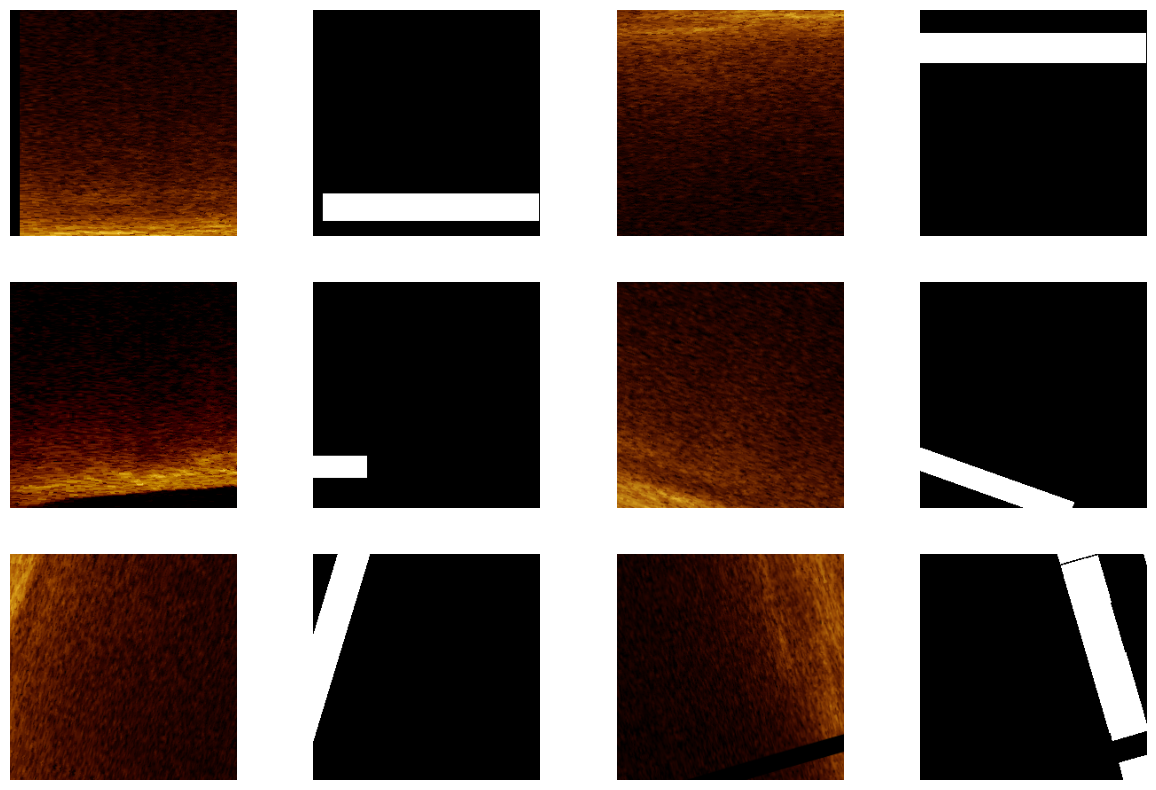

In [11]:
train_dataset = HuBMAPDataset('data/train-1', train_df, train=True, transform=get_transform('base'))

# 可视化数据增强后的图像和掩码
vis_aug_data(train_dataset, 6)

Image IDs from DataFrame: ['1-1-1.png' '1-1-2.png' '1-1-3.png' '1-1-8.png' '1-1-9.png' '10-1-1.png'
 '10-1-2.png' '10-1-3.png' '10-1-4.png' '10-1-5.png' '10-1-6.png'
 '10-1-7.png' '10-1-8.png' '10-1-9.png' '2-1-1.png' '2-1-4.png'
 '2-1-5.png' '2-1-6.png' '2-1-7.png' '2-1-8.png' '2-1-9.png' '3-1-1.png'
 '3-1-2.png' '3-1-5.png' '3-1-6.png' '3-1-7.png' '3-1-7.png' '3-1-8.png'
 '3-1-9.png' '3-1-9.png' '4-1-1.png' '4-1-2.png' '4-1-5.png' '4-1-5.png'
 '4-1-6.png' '4-1-7.png' '4-1-8.png' '4-1-9.png' '5-1-1.png' '5-1-4.png'
 '5-1-5.png' '5-1-6.png' '5-1-6.png' '5-1-7.png' '5-1-8.png' '5-1-9.png'
 '6-1-1.png' '6-1-2.png' '6-1-3.png' '6-1-4.png' '6-1-5.png' '6-1-6.png'
 '6-1-7.png' '6-1-8.png' '6-1-8.png' '6-1-9.png' '7-1-1.png' '7-1-2.png'
 '7-1-3.png' '7-1-4.png' '7-1-5.png' '7-1-6.png' '7-1-7.png' '7-1-8.png'
 '7-1-8.png' '7-1-9.png' '7-1-9.png' '8-1-1.png' '8-1-1.png' '8-1-2.png'
 '8-1-2.png' '8-1-3.png' '8-1-3.png' '8-1-4.png' '8-1-4.png' '8-1-5.png'
 '8-1-6.png' '8-1-7.png' '8-1-8.png' '8-

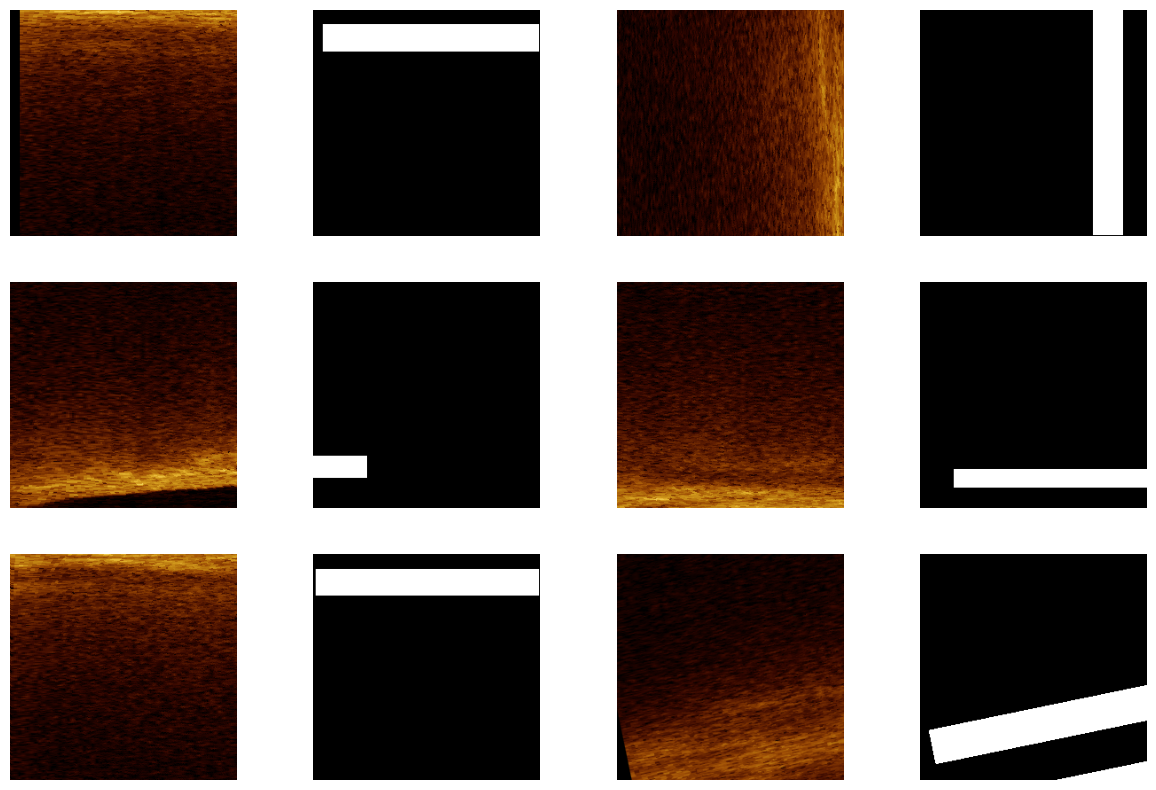

In [12]:
# weak augmentation
train_dataset = HuBMAPDataset('data/train-1', train_df, train=True, transform=get_transform('weak'))

vis_aug_data(train_dataset, 6)

Image IDs from DataFrame: ['1-1-1.png' '1-1-2.png' '1-1-3.png' '1-1-8.png' '1-1-9.png' '10-1-1.png'
 '10-1-2.png' '10-1-3.png' '10-1-4.png' '10-1-5.png' '10-1-6.png'
 '10-1-7.png' '10-1-8.png' '10-1-9.png' '2-1-1.png' '2-1-4.png'
 '2-1-5.png' '2-1-6.png' '2-1-7.png' '2-1-8.png' '2-1-9.png' '3-1-1.png'
 '3-1-2.png' '3-1-5.png' '3-1-6.png' '3-1-7.png' '3-1-7.png' '3-1-8.png'
 '3-1-9.png' '3-1-9.png' '4-1-1.png' '4-1-2.png' '4-1-5.png' '4-1-5.png'
 '4-1-6.png' '4-1-7.png' '4-1-8.png' '4-1-9.png' '5-1-1.png' '5-1-4.png'
 '5-1-5.png' '5-1-6.png' '5-1-6.png' '5-1-7.png' '5-1-8.png' '5-1-9.png'
 '6-1-1.png' '6-1-2.png' '6-1-3.png' '6-1-4.png' '6-1-5.png' '6-1-6.png'
 '6-1-7.png' '6-1-8.png' '6-1-8.png' '6-1-9.png' '7-1-1.png' '7-1-2.png'
 '7-1-3.png' '7-1-4.png' '7-1-5.png' '7-1-6.png' '7-1-7.png' '7-1-8.png'
 '7-1-8.png' '7-1-9.png' '7-1-9.png' '8-1-1.png' '8-1-1.png' '8-1-2.png'
 '8-1-2.png' '8-1-3.png' '8-1-3.png' '8-1-4.png' '8-1-4.png' '8-1-5.png'
 '8-1-6.png' '8-1-7.png' '8-1-8.png' '8-

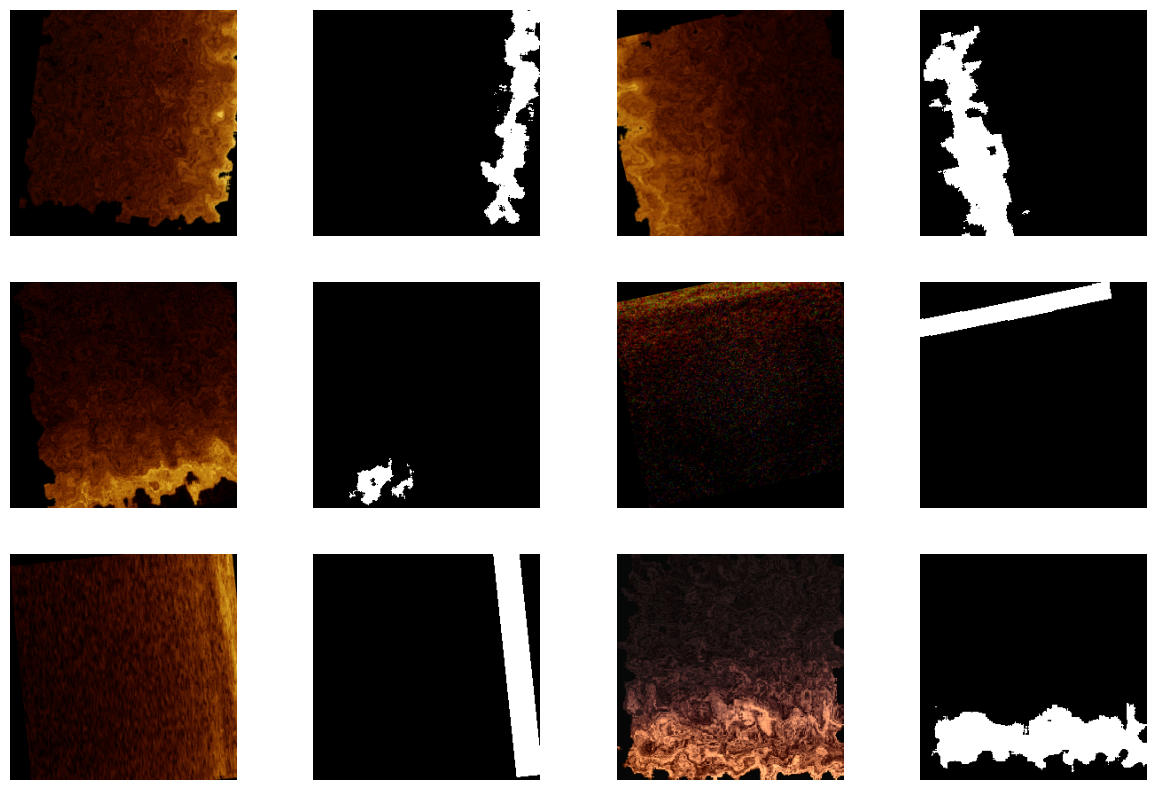

In [13]:
# strong augmentation
train_dataset = HuBMAPDataset('data/train-1', train_df, train=True, transform=get_transform('strong'))

vis_aug_data(train_dataset, 6)

Image IDs from DataFrame: ['1-1-1.png' '1-1-2.png' '1-1-3.png' '1-1-8.png' '1-1-9.png' '10-1-1.png'
 '10-1-2.png' '10-1-3.png' '10-1-4.png' '10-1-5.png' '10-1-6.png'
 '10-1-7.png' '10-1-8.png' '10-1-9.png' '2-1-1.png' '2-1-4.png'
 '2-1-5.png' '2-1-6.png' '2-1-7.png' '2-1-8.png' '2-1-9.png' '3-1-1.png'
 '3-1-2.png' '3-1-5.png' '3-1-6.png' '3-1-7.png' '3-1-7.png' '3-1-8.png'
 '3-1-9.png' '3-1-9.png' '4-1-1.png' '4-1-2.png' '4-1-5.png' '4-1-5.png'
 '4-1-6.png' '4-1-7.png' '4-1-8.png' '4-1-9.png' '5-1-1.png' '5-1-4.png'
 '5-1-5.png' '5-1-6.png' '5-1-6.png' '5-1-7.png' '5-1-8.png' '5-1-9.png'
 '6-1-1.png' '6-1-2.png' '6-1-3.png' '6-1-4.png' '6-1-5.png' '6-1-6.png'
 '6-1-7.png' '6-1-8.png' '6-1-8.png' '6-1-9.png' '7-1-1.png' '7-1-2.png'
 '7-1-3.png' '7-1-4.png' '7-1-5.png' '7-1-6.png' '7-1-7.png' '7-1-8.png'
 '7-1-8.png' '7-1-9.png' '7-1-9.png' '8-1-1.png' '8-1-1.png' '8-1-2.png'
 '8-1-2.png' '8-1-3.png' '8-1-3.png' '8-1-4.png' '8-1-4.png' '8-1-5.png'
 '8-1-6.png' '8-1-7.png' '8-1-8.png' '8-

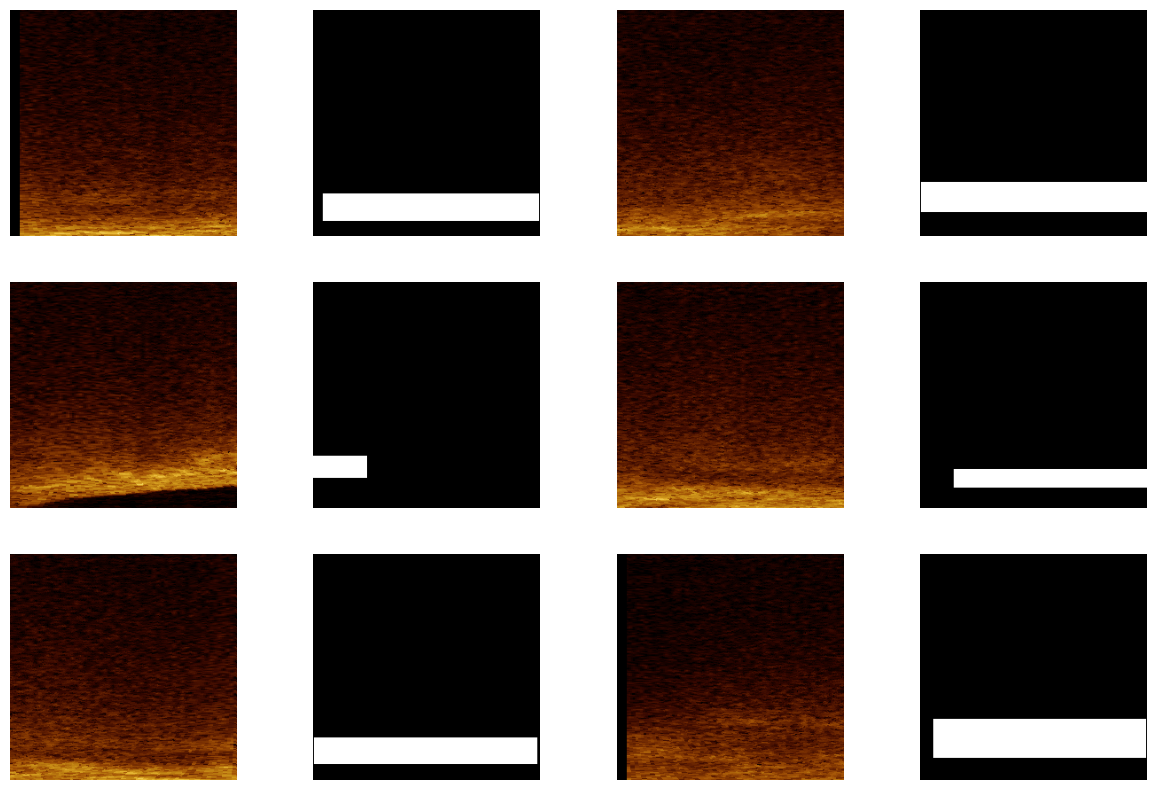

In [14]:
# valid augmentation
train_dataset = HuBMAPDataset('data/train-1', train_df, train=True, transform=get_transform('valid'))

vis_aug_data(train_dataset, 6)

DataLoader

In [15]:
directory_list = os.listdir('data/train-1')
directory_list = [fnames.split('_')[0] for fnames in directory_list]
dir_df = pd.DataFrame(directory_list, columns=['id'])
dir_df

,id
0,1-1-1.png
1,1-1-2.png
2,1-1-3.png
3,1-1-4.png
4,1-1-5.png
...,...
85,9-1-5.png
86,9-1-6.png
87,9-1-7.png
88,9-1-8.png


Model

In [16]:
from networks.vit_seg_modeling import VisionTransformer as ViT_seg
from networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg


# 配置 VisionTransformer
config_vit = CONFIGS_ViT_seg[CFG.MODEL_NAME]
config_vit.n_classes = 1
config_vit.n_skip = 3
config_vit.pretrained_path = './R50+ViT-B_16.npz'
config_vit.transformer.dropout_rate = 0.2
config_vit.transformer.mlp_dim = 3072
config_vit.transformer.num_heads = 12
config_vit.transformer.num_layers = 12

# 打印模型配置
print("Model Configuration:")
print(f"mlp_dim: {config_vit.transformer.mlp_dim}")
print(f"num_heads: {config_vit.transformer.num_heads}")

# 加载预训练模型文件
model_path = config_vit.pretrained_path
model_data = np.load(model_path)

# 打印预训练模型文件的所有键
print("Pretrained Weights Keys:")
for key in model_data.files:
    print(key)

# 修正路径分隔符
fixed_model_data = {}
for key in model_data.files:
    fixed_key = key.replace('\\', '/')
    fixed_model_data[fixed_key] = model_data[key]

# 打印修正后的预训练权重的形状
print("Fixed Pretrained Weights Shapes:")
for key in fixed_model_data:
    print(f"{key}: {fixed_model_data[key].shape}")

# 初始化 VisionTransformer 模型
model = ViT_seg(config_vit, img_size=CFG.img_size, num_classes=config_vit.n_classes)

# 加载修正后的预训练权重
try:
    model.load_from(fixed_model_data)
except KeyError as e:
    print(f"KeyError: {e}")
    missing_key = str(e).strip("'")
    if missing_key in fixed_model_data:
        print(f"Found key in fixed_model_data: {missing_key}")
    else:
        print(f"Key not found in fixed_model_data: {missing_key}")

# 打印模型配置
print(config_vit)

Model Configuration:
mlp_dim: 3072
num_heads: 12
Pretrained Weights Keys:
Transformer/encoder_norm/bias
Transformer/encoder_norm/scale
Transformer/encoderblock_0/LayerNorm_0/bias
Transformer/encoderblock_0/LayerNorm_0/scale
Transformer/encoderblock_0/LayerNorm_2/bias
Transformer/encoderblock_0/LayerNorm_2/scale
Transformer/encoderblock_0/MlpBlock_3/Dense_0/bias
Transformer/encoderblock_0/MlpBlock_3/Dense_0/kernel
Transformer/encoderblock_0/MlpBlock_3/Dense_1/bias
Transformer/encoderblock_0/MlpBlock_3/Dense_1/kernel
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/key/bias
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/key/kernel
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/out/bias
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/out/kernel
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/query/bias
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/query/kernel
Transformer/encoderblock_0/MultiHeadDotProductAttention_1/value/bia

In [17]:
class ViTHuBMAP(nn.Module):
    def __init__(self, configs=config_vit):
        super(ViTHuBMAP, self).__init__()
        
        self.model = ViT_seg(configs, img_size=CFG.img_size, num_classes=CFG.classes)
        self.model.load_from(weights=np.load(configs.pretrained_path))

    
    def forward(self, x):
        img_segs = self.model(x)
        
        return img_segs

Loss Function

In [18]:
sys.path.append('SegLossOdyssey-master')
from losses_pytorch.hausdorff import HausdorffDTLoss
from losses_pytorch.lovasz_loss import LovaszSoftmax
from losses_pytorch.focal_loss import FocalLoss

In [19]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=CFG.smoothing):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return dice
    
    
    
class DiceBCELoss(nn.Module):
    # Formula Given above.
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=CFG.smoothing):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).mean()                            
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.mean() + targets.mean() + smooth)  
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss
        
        return Dice_BCE.mean()
    
    
class Hausdorff_loss(nn.Module):
    def __init__(self):
        super(Hausdorff_loss, self).__init__()
        
    def forward(self, inputs, targets):
        return HausdorffDTLoss()(inputs, targets)
    
class FocalDLoss(nn.Module):
    def __init__(self):
        super(FocalDLoss, self).__init__()
        
    def forward(self, inputs, targets):
        return FocalLoss()(inputs, targets)
    
    
class Lovasz_loss(nn.Module):
    def __init__(self):
        super(Lovasz_loss, self).__init__()
        
    def forward(self, inputs, targets):
        return LovaszSoftmax()(inputs, targets)

In [20]:
if CFG.criterion == 'DiceBCELoss':
    criterion = DiceBCELoss()
elif CFG.criterion == 'DiceLoss':
    criterion = DiceLoss()
elif CFG.criterion == 'FocalLoss':
    criterion = FocalDLoss()
elif CFG.criterion == 'Hausdorff':
    criterion = Hausdorff_loss()
elif CFG.criterion == 'Lovasz':
    criterion = Lovasz_loss()

Train Function

In [21]:
def HuBMAPLoss(images, targets, model, device, loss_func=criterion):
    model.to(device)
    images = images.to(device)
    targets = targets.to(device)
    outputs = model(images)
    loss_func = loss_func
    loss = loss_func(outputs, targets)
    return loss, outputs

In [22]:
def train_one_epoch(epoch, model, device, optimizer, scheduler, trainloader):
    model.train()
    t = time.time()
    total_loss = 0
    
    for step, (images, targets) in enumerate(trainloader):
        loss, outputs = HuBMAPLoss(images, targets, model, device)
        loss.backward()
        if ((step+1)%4==0 or (step+1)==len(trainloader)):
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()
        loss = loss.detach().item()
        total_loss += loss
        
        if ((step+1)%10==0 or (step+1)==len(trainloader)):
            print(
                    f'epoch {epoch} train step {step+1}/{len(trainloader)}, ' + \
                    f'loss: {total_loss/len(trainloader):.4f}, ' + \
                    f'time: {(time.time() - t):.4f}', end= '\r' if (step + 1) != len(trainloader) else '\n'
                )

            
        
def valid_one_epoch(epoch, model, device, optimizer, scheduler, validloader):
    model.eval()
    t = time.time()
    total_loss = 0
    
    for step, (images, targets) in enumerate(validloader):
        loss, outputs = HuBMAPLoss(images, targets, model, device)
        loss = loss.detach().item()
        total_loss += loss
        
        if ((step+1)%4==0 or (step+1)==len(validloader)):
            scheduler.step(total_loss/len(validloader))
        
        if ((step+1)%10==0 or (step+1)==len(validloader)):
            print(
                    f'**epoch {epoch} trainz step {step+1}/{len(validloader)}, ' + \
                    f'loss: {total_loss/len(validloader):.4f}, ' + \
                    f'time: {(time.time() - t):.4f}', end= '\r' if (step + 1) != len(validloader) else '\n'
                )

        

In [23]:
# FOLDS = CFG.n_fold
# gkf = GroupKFold(FOLDS)
# dir_df['Folds'] = 0
# for fold, (tr_idx, val_idx) in enumerate(gkf.split(dir_df, groups=dir_df[dir_df.columns[0]].values)):
#     dir_df.loc[val_idx, 'Folds'] = fold
    
# dir_df

FOLDS = CFG.n_fold
gkf = StratifiedKFold(FOLDS)
dir_df['Folds'] = 0
for fold, (tr_idx, val_idx) in enumerate(gkf.split(dir_df, [1]*len(dir_df))):
    dir_df.loc[val_idx, 'Folds'] = fold
    
dir_df

,id,Folds
0,1-1-1.png,0
1,1-1-2.png,0
2,1-1-3.png,0
3,1-1-4.png,0
4,1-1-5.png,0
...,...,...
85,9-1-5.png,4
86,9-1-6.png,4
87,9-1-7.png,4
88,9-1-8.png,4


Real Training

In [24]:
def prepare_train_valid_dataloader(df, fold):
    train_ids = df[~df.Folds.isin(fold)]
    val_ids = df[df.Folds.isin(fold)]
    
    train_ds = HuBMAPDataset('data/train-1', train_ids, train=True, transform=get_transform('base'))
    val_ds = HuBMAPDataset('data/train-1', val_ids, train=True, transform=get_transform('valid'))
    
    train_loader = DataLoader(train_ds, batch_size=CFG.batch_size, pin_memory=True, shuffle=True, num_workers=CFG.num_workers)
    val_loader = DataLoader(val_ds, batch_size=CFG.batch_size, pin_memory=True, shuffle=False, num_workers=CFG.num_workers)
    
    return train_loader, val_loader



In [27]:
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
print(device)

# 初始化模型并移动到设备
model = ViTHuBMAP().to(device)

# 初始化优化器
optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)

# 设置学习率调度器
if CFG.scheduler == 'CosineAnnealingWarmRestarts':
    scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
elif CFG.scheduler == 'ReduceLROnPlateau':
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
elif CFG.scheduler == 'CosineAnnealingLR':
    scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)

True
cuda
load_pretrained: grid-size from 14 to 16


In [28]:
print(f'Training Loop [{CFG.trn_fold}]...')
print(dir_df[dir_df.columns[5]].values)
for fold, (tr_idx, val_idx) in enumerate(gkf.split(dir_df,[1]*len(dir_df))):
    if fold != CFG.trn_fold: # Train only one fold
        continue 

    trainloader, validloader = prepare_train_valid_dataloader(dir_df, [fold])

    for epoch in range(CFG.epoch):
        train_one_epoch(epoch, model, device, optimizer, scheduler, trainloader)
        with torch.no_grad():
            valid_one_epoch(epoch, model, device, optimizer, scheduler, validloader)
        
        #torch.save(model.state_dict(),f'FOLD-{fold}-EPOCH-{epoch}-model.pth')
        
    torch.save(model.state_dict(),f'FOLD-{fold}-model.pth')
    
    #del model, optimizer, scheduler, trainloader, validloader

Training Loop [0]...


IndexError: index 5 is out of bounds for axis 0 with size 2

In [ ]:
trainloader, validloader = prepare_train_valid_dataloader(dir_df, [4])

AttributeError: 'DataFrame' object has no attribute 'Folds'